In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas
from geopy import geocoders
import geopy
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Datasets

We will import:

- The ccai dataset provided by widsDatathon2022

- The original dataset provided by  the ministry of Ecological Transition

- Census data obtained from the INSEE: https://www.insee.fr/fr/statistiques/5542859?sommaire=5395764#dictionnaire

In [2]:
ccai = pd.read_csv('../input/phase-ii-widsdatathon2022/ccai/ccai/data.csv')
ccai.columns

Index(['id', 'geometry', 'address', 'city_name', 'consumption',
       'delivery_points', 'coords_eobs', 'qq_dict', 'height', 'type', 'age',
       'floors', 'alt_prec', 'wall_mat', 'roof_mat'],
      dtype='object')

In [3]:
original= pd.read_csv('../input/original-dataset/original2019.csv', delimiter=";", header=1)

In [4]:
ccai.head()

,id,geometry,address,city_name,consumption,delivery_points,coords_eobs,qq_dict,height,type,age,floors,alt_prec,wall_mat,roof_mat
0,BATIMENT0000000267007025,"POLYGON ((831362.2 6287883.7, 831358.5 6287883...",20 RUE DES ARENES,ARLES,73.40591,10,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",16.2,Indifférencié,NaN,NaN,1.0,NaN,NaN
1,BATIMENT0000000296359233,"POLYGON ((865664.7 6324289.7, 865661.4 6324287...",215 AVENUE RENE CHAR,PERNES-LES-FONTAINES,141.82340,21,"(43.949860575200006, 5.049860370800005)","{1: 2455.0, 2: 1814.0, 3: 2851.0, 4: 3557.0, 5...",4.3,Indifférencié,NaN,NaN,1.0,NaN,NaN
2,BATIMENT0000002206959400,"POLYGON ((853561.7 6321230.3, 853566 6321226.6...",180 RUE DU GRAND PLANTIER,VEDÈNE,162.46720,54,"(43.949860575200006, 4.949860371200003)","{1: 2457.0, 2: 1800.0, 3: 2848.0, 4: 3558.0, 5...",11.2,Indifférencié,NaN,NaN,1.5,NaN,NaN
3,BATIMENT0000002207873218,"POLYGON ((958628 6338138.9, 958637.9 6338142.8...",19 AVENUE DES CHARROIS,DIGNE-LES-BAINS,93.80699,19,"(44.0498605748, 6.249860366000004)","{1: 2499.0, 2: 1835.0, 3: 3009.0, 4: 3811.0, 5...",16.3,Indifférencié,NaN,NaN,1.5,NaN,NaN
4,BATIMENT0000000267000847,"POLYGON ((830443.5 6286844.6, 830479.9 6286830...",8 PLACE DES TROUBADOURS,ARLES,25.56239,23,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",5.4,Indifférencié,NaN,NaN,1.0,NaN,NaN


We will merge the original dataset with the ccai dataset to obtain the **IRIS code** for each building. We will use this code as a category for buildings that share the same zone, and it will be useful for merging our dataset to the census data.

"In French, IRIS is an acronym of ‘aggregated units for statistical information’. These units respect geographic and demographic criteria and have borders which are clearly identifiable and stable in the long term.
Towns with more than 10,000 inhabitants, and a large proportion of towns with between 5,000 and 10,000 inhabitants, are divided into several IRIS units. This separation represents a division of the territory. By extension, in order to cover the whole of the country, all towns not divided into IRIS units constitute IRIS units in themselves."
https://www.insee.fr/en/metadonnees/definition/c1523

Those IRIS zones were introduced in 1999 and updated in 2008 to perform
country-wide statistical analyses based on the national census. Each IRIS zone has an identifierthat is divided into three parts: 
The first two digits denote the département, which is an upper-level administrational unit, the following three digits identify a commune (municipality) within
this département, and the last four digits describe the statistical IRIS zone in that municipality.
It is important to note that not all communes may be divided into IRIS, mainly if they have less than 10,000 inhabitants.
https://www.sciencedirect.com/science/article/pii/S2352340921008970

In [5]:
ccai.shape

(55169, 15)

In [6]:
ccai = ccai.merge(original[["IRIS_CODE", "ADRESSE", "NOM_COMMUNE", "PDL"]].drop_duplicates(), left_on=["address", "city_name","delivery_points"], right_on=["ADRESSE","NOM_COMMUNE", "PDL"])
ccai.drop(columns=["ADRESSE", "NOM_COMMUNE", "PDL"], inplace=True)

In [7]:
ccai.head()

,id,geometry,address,city_name,consumption,delivery_points,coords_eobs,qq_dict,height,type,age,floors,alt_prec,wall_mat,roof_mat,IRIS_CODE
0,BATIMENT0000000267007025,"POLYGON ((831362.2 6287883.7, 831358.5 6287883...",20 RUE DES ARENES,ARLES,73.40591,10,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",16.2,Indifférencié,NaN,NaN,1.0,NaN,NaN,130040102
1,BATIMENT0000000267005618,"POLYGON ((831356.7 6287879.5, 831375 6287878.8...",20 RUE DES ARENES,ARLES,73.40591,10,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",15.9,Résidentiel,1800-01-01,4.0,1.0,20.0,10.0,130040102
2,BATIMENT0000000267007027,"POLYGON ((831362.2 6287883.7, 831362 6287892.7...",20 RUE DES ARENES,ARLES,73.40591,10,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",15.6,Résidentiel,1987-01-01,4.0,1.0,10.0,10.0,130040102
3,BATIMENT0000000267007037,"POLYGON ((831368.4 6287883.9, 831368.1 6287889...",20 RUE DES ARENES,ARLES,73.40591,10,"(43.6498605764, 4.649860372400003)","{1: 2592.0, 2: 2067.0, 3: 3237.0, 4: 4076.0, 5...",15.2,Résidentiel,1987-01-01,3.0,1.0,10.0,10.0,130040102
4,BATIMENT0000000296359233,"POLYGON ((865664.7 6324289.7, 865661.4 6324287...",215 AVENUE RENE CHAR,PERNES-LES-FONTAINES,141.82340,21,"(43.949860575200006, 5.049860370800005)","{1: 2455.0, 2: 1814.0, 3: 2851.0, 4: 3557.0, 5...",4.3,Indifférencié,NaN,NaN,1.0,NaN,NaN,840880103


In [8]:
census = pd.read_csv('../input/census/census_prepared_IRIS_2018.csv', encoding="latin")


## Type of building

In [9]:
ccai["type"].value_counts()

Résidentiel               43125
Indifférencié              9985
Commercial et services     1267
Annexe                      744
Industriel                   31
Sportif                      11
Religieux                     6
Name: type, dtype: int64

# Roof mat and wall mat

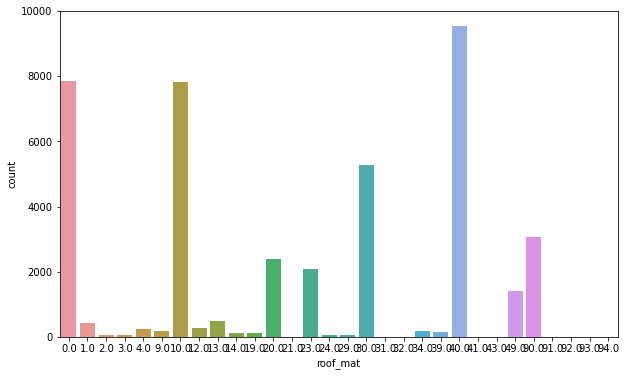

In [10]:
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.countplot(data=ccai, x='roof_mat')
plt.show()

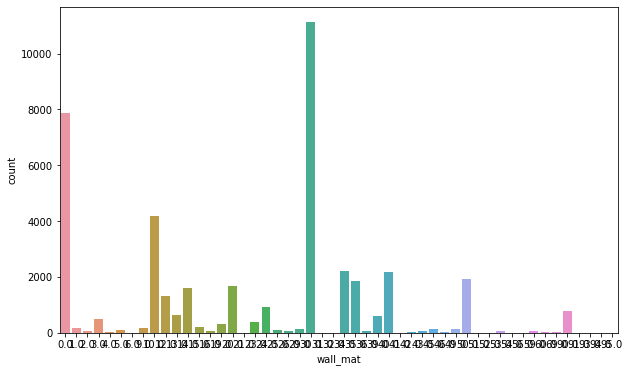

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.countplot(data=ccai, x='wall_mat')
plt.show()

In [12]:
ccai['roof_wall'] = ccai[['roof_mat', 'wall_mat']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

## Working with the geometry variable

We parse the geometry variable to work with it from geopandas

In [13]:
ccai['geometry'] = geopandas.GeoSeries.from_wkt(ccai['geometry'])
gdf = geopandas.GeoDataFrame(ccai, geometry='geometry')

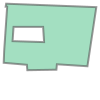

In [14]:
ccai["geometry"][1]

In [15]:
print(gdf.crs)

None


Since we do not have a crs we have to set the corresponding crs to the geometry column. In France, it is common to use the projection 2154

In [16]:
gdf = gdf.set_crs('epsg:2154')
print(gdf.crs)

epsg:2154


Now we are able to calculate the area of the polygon

In [17]:
gdf['area'] = gdf.geometry.area

By calculating the polygon centroid, we calculate the coordinates of the building

In [18]:
gdf['polygon_centroid'] = gdf.geometry.centroid
#Change the CRS to longitude, latitude
gdf["polygon_centroid"]= gdf["polygon_centroid"].to_crs(4326)

In [19]:
gdf["Lon"]= gdf.polygon_centroid.x
gdf['Lat'] = gdf.polygon_centroid.y

<AxesSubplot:>

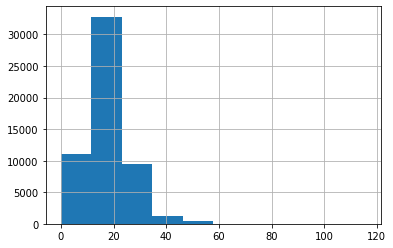

In [20]:
gdf["height"].hist()

In [21]:
gdf.height = np.where(gdf.height == 0, np.nan, gdf.height)

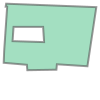

In [22]:
ccai["geometry"][1]

We calculate the building volume

In [23]:
gdf["volume"] = gdf["area"]*gdf["height"]

In [24]:
gdf["volume_per_floor"] = gdf["volume"]/gdf["floors"]

In [25]:
for i in ["roof_mat", "wall_mat"]:
    gdf[i]=gdf[i].astype('object')

In [26]:
gdf.corr().abs()['consumption'].sort_values(ascending=False).head(40)

consumption         1.000000
floors              0.211700
volume              0.209520
height              0.199018
area                0.152891
delivery_points     0.102997
volume_per_floor    0.074566
Lon                 0.062541
Lat                 0.019563
alt_prec            0.011153
Name: consumption, dtype: float64

## Age variable

In [27]:
gdf["age"]= gdf["age"].str[:4]

In [28]:
gdf["age"] = gdf["age"].astype('float')

## City and IRIS variables

We create new variables related to the mean consumption in the same city and the mean consumption in the same zone (same IRIS code)

In [29]:
gdf["mean_cons_IRIS"] = gdf.groupby("IRIS_CODE")["consumption"].transform('mean')
gdf["mean_cons_city"] = gdf.groupby("city_name")["consumption"].transform('mean')
gdf["count_IRIS"] = gdf.groupby("IRIS_CODE")["consumption"].transform('count')
gdf["count_city"] = gdf.groupby("city_name")["consumption"].transform('count')

#gdf["mean_cons_IRIS"] = (gdf["mean_cons_IRIS"] - gdf["consumption"]/gdf["count_IRIS"])*(gdf["count_IRIS"]/(gdf["count_IRIS"]-1))
#gdf["mean_cons_city"] = (gdf["mean_cons_city"] - gdf["consumption"]/gdf["count_city"])*(gdf["count_city"]/(gdf["count_city"]-1))

gdf["mean_cons_IRIS"] = np.round(gdf["mean_cons_IRIS"],0)
gdf["mean_cons_city"] = np.round(gdf["mean_cons_city"],0)


#If there are not several buildings per city, this value is considered null
gdf.loc[gdf["count_IRIS"]<5,"mean_cons_IRIS"] = np.nan
gdf.loc[gdf["count_city"]<5,"mean_cons_city"] = np.nan

In [30]:
gdf[gdf["count_IRIS"]<4].shape

(4836, 27)

In [31]:
gdf.corr()['consumption'].sort_values(ascending=False).head(40)

consumption         1.000000
mean_cons_IRIS      0.698115
mean_cons_city      0.394707
delivery_points     0.102997
Lon                 0.062541
count_city          0.009154
alt_prec           -0.011153
Lat                -0.019563
volume_per_floor   -0.074566
count_IRIS         -0.085995
age                -0.102812
area               -0.152891
height             -0.199018
volume             -0.209520
floors             -0.211700
Name: consumption, dtype: float64

**correlation between consumptions and means_cons_IRIS**: The building consumption display singnificant correlation (0,63) with the mean consumption of the same IRIS zone

In [32]:
#gdf.groupby("mean_cons_IRIS")["consumption"].mean().plot(title="mean_cons_IRIS vs consumption")

### We merge the dataset with the CENSUS data

In [33]:
census = np.round(census,2)

In [34]:
cs = [x for x in census.columns if "CS1" in x]
census = census[[x for x in census.columns if x not in cs]]

In [35]:
census.head()

,IRIS,CHFL_1,CHFL_2,CHFL_3,CHFL_4,CHFL_X,CHFL_Z,CMBL_1,CMBL_2,CMBL_3,...,CHFL1_CMBL_2,CHFL1_CMBL_3,CHFL1_CMBL_4,CHFL1_CMBL_5,CHFL1_CMBL_6,CHFL2_CMBL_2,CHFL2_CMBL_3,CHFL2_CMBL_4,CHFL2_CMBL_5,CHFL2_CMBL_6
0,010040101,0.07,0.57,0.25,0.01,0.09,NaN,0.02,0.47,0.06,...,0.01,0.01,0.01,0.02,NaN,0.45,0.04,0.06,0.00,0.02
1,010040102,0.41,0.37,0.20,0.02,NaN,NaN,0.07,0.52,0.11,...,0.21,0.08,0.03,0.01,0.01,0.30,0.03,0.02,0.01,0.01
2,010040201,0.28,0.47,0.20,0.03,0.01,NaN,0.02,0.55,0.11,...,0.15,0.08,0.01,0.01,NaN,0.40,0.03,0.03,0.00,0.01
3,010040202,0.01,0.65,0.25,0.08,0.01,NaN,0.00,0.48,0.06,...,0.01,0.00,0.00,NaN,NaN,0.47,0.05,0.06,0.00,0.06
4,010330102,0.38,0.13,0.48,0.01,NaN,NaN,0.08,0.09,0.17,...,0.07,0.12,0.11,0.01,NaN,0.02,0.04,0.06,0.00,0.01


In [36]:
gdf=gdf.merge(census, left_on="IRIS_CODE", right_on="IRIS", how="left")

In [37]:
gdf.drop(columns=["IRIS"], inplace=True)

**CHFL**: Central heating of housing (metropolitan France): We calculated the percentage of individuals per IRIS area with each of the following central heatings:

    1: Collective central heating (including urban heating)

    2: Individual central heating with a boiler specific to the accommodation

    3: All-electric heating

    4: Other heating way

    X: Excluding ordinary housing (DOM and metropolitan France)

    Y: Excluding main residence

    Z: Ordinary DOM housing

**CMBL**: Main household fuel (metropolitan France): We calculated the percentage of individuals per IRIS area with each of the following household fuels:

    1: Urban heating

    2: Gas Network

    3: Fuel oil (oil)

    4: Electricity
    
    5: Gas in cylinders or in tanks
    
    6: Other

    X: Excluding ordinary housing (DOM and metropolitan France)

    Y: Excluding main residence

    Z: Ordinary DOM housing

**CHFL_CMBL**:  We calculated the percentage of individuals per IRIS area with a combination of specific type of central heating and main fuel.

**NPERR**: Number of people in the household (grouped): We calculated the percentage of individuals per IRIS area with each of the following number of people in the household:

    1: One person

    2: Two people

    3: Three people

    4: Four people
    
    5: Five people
 
    6: Six or more

    Z: Excluding ordinary housing (DOM and metropolitan France)

   

**STATR**: Grouped professional status: We calculated the percentage of individuals per IRIS area with this status:

    1: Employee 

    2: Non salaried (self employed. This denomination affects liberals, artisans, merchants, etc. : professions not being remunerated by means of a salary.)

    Z: Not applicable

In [38]:
gdf.isna().sum()

id                  0
geometry            0
address             0
city_name           0
consumption         0
                ...  
CHFL2_CMBL_2     1664
CHFL2_CMBL_3    20894
CHFL2_CMBL_4     4155
CHFL2_CMBL_5    31326
CHFL2_CMBL_6    30730
Length: 68, dtype: int64

In [39]:
gdf.corr()['consumption'].sort_values(ascending=False)

consumption         1.000000
mean_cons_IRIS      0.698115
mean_cons_city      0.394707
CHFL_2              0.350085
CHFL2_CMBL_2        0.342115
STATR_2             0.273400
CMBL_4              0.259396
NENFR_0             0.256409
CHFL_3              0.253718
NPERR_2             0.230528
STATR_1             0.227761
CMBL_2              0.205546
NENFR_Z             0.175426
NPERR_1             0.169948
CHFL2_CMBL_4        0.144734
delivery_points     0.102997
Lon                 0.062541
CHFL_4              0.032847
CHFL2_CMBL_3        0.032761
CMBL_X              0.013788
CHFL_X              0.013788
NPERR_Z             0.013788
CHFL2_CMBL_6        0.011424
count_city          0.009154
CMBL_3             -0.009099
alt_prec           -0.011153
CHFL2_CMBL_5       -0.014622
Lat                -0.019563
CHFL1_CMBL_3       -0.025831
CMBL_5             -0.032861
CHFL1_CMBL_5       -0.050685
NPERR_3            -0.052940
NENFR_2            -0.073163
volume_per_floor   -0.074566
NPERR_4       

There is negative correlation between our target and the variable CHFL_1,  CMBL_1 and CHFL1_CMBL_1. It suggests that the higher the percentage of urbain heating in an IRIS area, the lower the gas consumption.

There is positive correlation between our target and variables CHFL_2 and CHFL2_CMBL_2. It suggests that the higher the presence individual central heatings (with a boiler specific to the accommodation) that use gas network, the higher the gas consumption. By contrast, when the type of heating is collective central heating that uses the gas network, the correlation sign reverts and become negative.

In [40]:
gdf[gdf["CMBL_1"]!= gdf["CHFL1_CMBL_1"]][["CMBL_1","CHFL1_CMBL_1", "IRIS_CODE"]]

,CMBL_1,CHFL1_CMBL_1,IRIS_CODE
0,NaN,NaN,130040102
1,NaN,NaN,130040102
2,NaN,NaN,130040102
3,NaN,NaN,130040102
4,NaN,NaN,840880103
...,...,...,...
55132,NaN,NaN,591310101
55133,NaN,NaN,591310101
55134,NaN,NaN,591310101
55137,NaN,NaN,593590102


<AxesSubplot:>

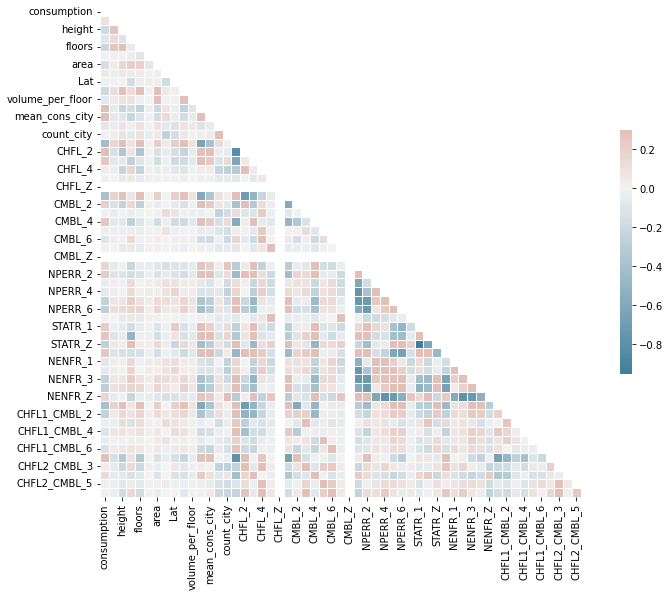

In [41]:
import seaborn as sns
# Compute the correlation matrix
corr = gdf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
#gdf[["NPERR_6","NPERR_5", "NPERR_4", "NPERR_3", "NPERR_2", "NPERR_1", "NPERR_Z"]] = gdf[["NPERR_6","NPERR_5", "NPERR_4", "NPERR_3", "NPERR_2", "NPERR_1", "NPERR_Z"]].fillna(0)

In [43]:
#gdf["n_people_ge5"]= np.round(gdf["NPERR_6"]+gdf["NPERR_5"],2)
#gdf["n_people_3_4"]= gdf["NPERR_3"]+gdf["NPERR_4"]
#gdf["n_people_1_2"]= gdf["NPERR_1"]+gdf["NPERR_2"]

<AxesSubplot:title={'center':'CHFL_1 vs consumption'}, xlabel='CHFL_1'>

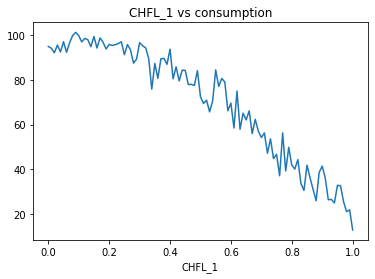

In [44]:
gdf.groupby("CHFL_1")["consumption"].mean().plot(title="CHFL_1 vs consumption")

<AxesSubplot:title={'center':'CHFL1_CMBL_1 vs consumption'}, xlabel='CHFL1_CMBL_1'>

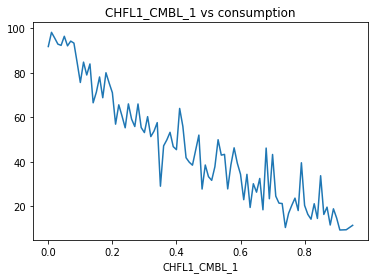

In [45]:
gdf.groupby("CHFL1_CMBL_1")["consumption"].mean().plot(title="CHFL1_CMBL_1 vs consumption")

<AxesSubplot:title={'center':'CHFL_2 vs consumption'}, xlabel='CHFL_2'>

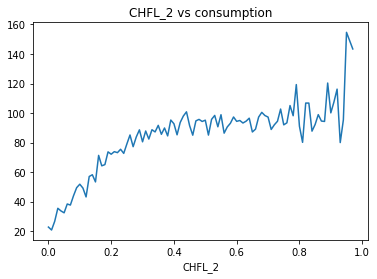

In [46]:
gdf.groupby("CHFL_2")["consumption"].mean().plot(title="CHFL_2 vs consumption")

<AxesSubplot:title={'center':'CHFL2_CMBL_2 vs consumption'}, xlabel='CHFL2_CMBL_2'>

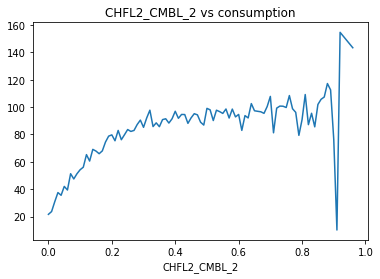

In [47]:
gdf.groupby("CHFL2_CMBL_2")["consumption"].mean().plot(title="CHFL2_CMBL_2 vs consumption")

<AxesSubplot:title={'center':'CHFL_1 vs consumption'}, xlabel='CHFL1_CMBL_2'>

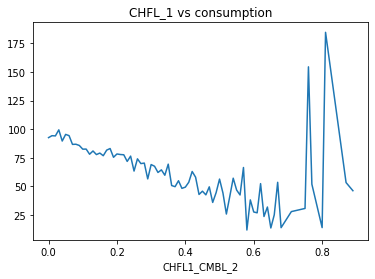

In [48]:
gdf.groupby("CHFL1_CMBL_2")["consumption"].mean().plot(title="CHFL_1 vs consumption")

<AxesSubplot:title={'center':'CMBL_1 vs consumption'}, xlabel='CMBL_1'>

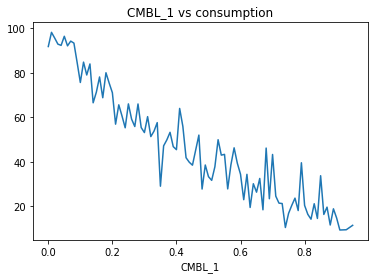

In [49]:
gdf.groupby("CMBL_1")["consumption"].mean().plot(title="CMBL_1 vs consumption")

<AxesSubplot:title={'center':'STATR_1 vs consumption'}, xlabel='STATR_1'>

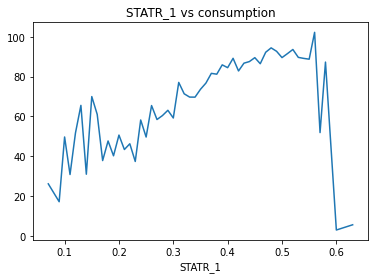

In [50]:
gdf.groupby("STATR_1")["consumption"].mean().plot(title="STATR_1 vs consumption")

<AxesSubplot:title={'center':'STATR_Z vs consumption'}, xlabel='STATR_Z'>

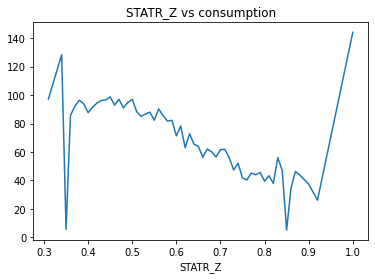

In [51]:
gdf.groupby("STATR_Z")["consumption"].mean().plot(title="STATR_Z vs consumption")

## Radiation variable

We parse the qq_dict variable to get one column for each dict key. Each column corresponds to a monthly measured radiation

In [52]:
gdf["qq_dict"]=gdf["qq_dict"].map(eval)

In [53]:
qqdf = gdf["qq_dict"].apply(pd.Series)

In [54]:
gdf2 = pd.concat([gdf.drop(['qq_dict'], axis=1), qqdf], axis=1)

In [55]:
rename_qq={}
for i in range(1,13):
    rename_qq[i] = f"qq_month_{i}"

In [56]:
gdf2.rename(columns=rename_qq, inplace=True)

In [57]:
gdf.corr()['consumption'].sort_values(ascending=False).head(40)

consumption         1.000000
mean_cons_IRIS      0.698115
mean_cons_city      0.394707
CHFL_2              0.350085
CHFL2_CMBL_2        0.342115
STATR_2             0.273400
CMBL_4              0.259396
NENFR_0             0.256409
CHFL_3              0.253718
NPERR_2             0.230528
STATR_1             0.227761
CMBL_2              0.205546
NENFR_Z             0.175426
NPERR_1             0.169948
CHFL2_CMBL_4        0.144734
delivery_points     0.102997
Lon                 0.062541
CHFL_4              0.032847
CHFL2_CMBL_3        0.032761
CMBL_X              0.013788
CHFL_X              0.013788
NPERR_Z             0.013788
CHFL2_CMBL_6        0.011424
count_city          0.009154
CMBL_3             -0.009099
alt_prec           -0.011153
CHFL2_CMBL_5       -0.014622
Lat                -0.019563
CHFL1_CMBL_3       -0.025831
CMBL_5             -0.032861
CHFL1_CMBL_5       -0.050685
NPERR_3            -0.052940
NENFR_2            -0.073163
volume_per_floor   -0.074566
NPERR_4       

In [58]:
qq_cols =[]
for i in range(1,13):
    qq_cols.append(f"qq_month_{i}")


In [59]:
gdf2["mean_month_qq"] = gdf2[qq_cols].mean(axis=1) 
    

In [60]:
gdf2.columns

Index(['id', 'geometry', 'address', 'city_name', 'consumption',
       'delivery_points', 'coords_eobs', 'height', 'type', 'age', 'floors',
       'alt_prec', 'wall_mat', 'roof_mat', 'IRIS_CODE', 'roof_wall', 'area',
       'polygon_centroid', 'Lon', 'Lat', 'volume', 'volume_per_floor',
       'mean_cons_IRIS', 'mean_cons_city', 'count_IRIS', 'count_city',
       'CHFL_1', 'CHFL_2', 'CHFL_3', 'CHFL_4', 'CHFL_X', 'CHFL_Z', 'CMBL_1',
       'CMBL_2', 'CMBL_3', 'CMBL_4', 'CMBL_5', 'CMBL_6', 'CMBL_X', 'CMBL_Z',
       'NPERR_1', 'NPERR_2', 'NPERR_3', 'NPERR_4', 'NPERR_5', 'NPERR_6',
       'NPERR_Z', 'STATR_1', 'STATR_2', 'STATR_Z', 'NENFR_0', 'NENFR_1',
       'NENFR_2', 'NENFR_3', 'NENFR_4', 'NENFR_Z', 'CHFL1_CMBL_1',
       'CHFL1_CMBL_2', 'CHFL1_CMBL_3', 'CHFL1_CMBL_4', 'CHFL1_CMBL_5',
       'CHFL1_CMBL_6', 'CHFL2_CMBL_2', 'CHFL2_CMBL_3', 'CHFL2_CMBL_4',
       'CHFL2_CMBL_5', 'CHFL2_CMBL_6', 'qq_month_1', 'qq_month_2',
       'qq_month_3', 'qq_month_4', 'qq_month_5', 'qq_month_6', 'q

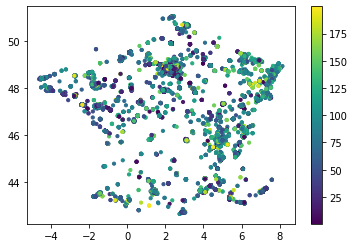

In [61]:
import matplotlib.pyplot as plt
plt.scatter(gdf2.Lon, gdf2.Lat, c=gdf2.consumption, s=10)
plt.colorbar()
plt.show()

In [62]:
gdf = gdf2

In [63]:
# Model

In [64]:
target = 'consumption'
id_col = 'id'

In [65]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in gdf.columns: 
    if gdf[i].dtypes == 'object' and i not in ["qq_dict"]:
        print(i) 
        gdf[i] = le.fit_transform(gdf[i])

id
address
city_name
coords_eobs
type
wall_mat
roof_mat
IRIS_CODE
roof_wall


In [66]:
gdf.shape

(55169, 80)

In [67]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(gdf, test_size=0.1, random_state=42)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

y_test = test[target]
test.drop(target, axis=1, inplace=True)

In [68]:
# Baseline without census data

In [69]:
features = [
 'delivery_points',
 'height',
 'age',
 'floors',
 'wall_mat',
 'roof_mat',
 'roof_wall',
 'area',
 'qq_month_1',
 'qq_month_2',
 'qq_month_3',
 'qq_month_4',
 'qq_month_5',
 'qq_month_6',
 'qq_month_7',
 'qq_month_8',
 'qq_month_9',
 'qq_month_10',
 'qq_month_11',
 'qq_month_12',
 'mean_month_qq']

In [70]:
X = train[features]
y = train[target]
y_oof_pred = np.zeros(len(y))

X_test = test[features].values
y_test_pred = np.zeros(len(X_test))

In [71]:
features

['delivery_points',
 'height',
 'age',
 'floors',
 'wall_mat',
 'roof_mat',
 'roof_wall',
 'area',
 'qq_month_1',
 'qq_month_2',
 'qq_month_3',
 'qq_month_4',
 'qq_month_5',
 'qq_month_6',
 'qq_month_7',
 'qq_month_8',
 'qq_month_9',
 'qq_month_10',
 'qq_month_11',
 'qq_month_12',
 'mean_month_qq']

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49652 entries, 0 to 49651
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   delivery_points  49652 non-null  int64  
 1   height           48293 non-null  float64
 2   age              35336 non-null  float64
 3   floors           39189 non-null  float64
 4   wall_mat         49652 non-null  int64  
 5   roof_mat         49652 non-null  int64  
 6   roof_wall        49652 non-null  int64  
 7   area             49652 non-null  float64
 8   qq_month_1       49652 non-null  float64
 9   qq_month_2       49652 non-null  float64
 10  qq_month_3       49652 non-null  float64
 11  qq_month_4       49652 non-null  float64
 12  qq_month_5       49652 non-null  float64
 13  qq_month_6       49652 non-null  float64
 14  qq_month_7       49652 non-null  float64
 15  qq_month_8       49652 non-null  float64
 16  qq_month_9       49652 non-null  float64
 17  qq_month_10 

In [73]:
error = 0
SEED=42

num_folds = 5
kf = KFold(n_splits = num_folds)

for i, (train_index, val_index) in enumerate(kf.split(X, y)):  
    print(f"Fold {i+1}")

    X_train = X.loc[train_index].values
    X_val = X.loc[val_index].values
    y_train = y[train_index].values
    y_val = y[val_index].values

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val)

    params_lgb = {
        'objective' : 'regression',
        'metric': 'rmse',
        'force_col_wise': True,
        'seed' : SEED,
        'num_iterations' : 15000,
        'early_stopping_rounds' : 250,
        'learning_rate' : 0.05,
        'max_depth' : 8,
        'num_leaves' : 32,
        'feature_fraction': 0.9,
        'lambda_l1' : 0.1,
        'lambda_l2' : 0.1,
        'verbose' : -1
    }

    model = lgb.train(params=params_lgb,
                      train_set=lgb_train,
                      valid_sets = (lgb_train, lgb_eval),
                      verbose_eval = 250,
                     )


    y_val_pred = model.predict(X_val)
    y_test_pred += model.predict(X_test)
    
    rmse_fold = np.sqrt(mean_squared_error(y_val_pred, y_val))
    error += rmse_fold
    y_oof_pred[val_index] = y_val_pred


print(f"Mean RMSE: {error/num_folds}")
print(f"Mean RMSE: {np.sqrt(mean_squared_error(y_oof_pred, y))}")


# Calculate evaluation metric for out of fold validation set
y_test_pred = y_test_pred / num_folds
print(f"Mean RMSE in test over the n folds: {np.sqrt(mean_squared_error(y_test_pred, y_test))}")


Fold 1
Training until validation scores don't improve for 250 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 35.8654	valid_1's rmse: 37.8864
[500]	training's rmse: 33.5161	valid_1's rmse: 36.9849
[750]	training's rmse: 31.9075	valid_1's rmse: 36.431
[1000]	training's rmse: 30.4699	valid_1's rmse: 36.0644
[1250]	training's rmse: 29.2954	valid_1's rmse: 35.8073
[1500]	training's rmse: 28.168	valid_1's rmse: 35.6348
[1750]	training's rmse: 27.2453	valid_1's rmse: 35.4832
[2000]	training's rmse: 26.3833	valid_1's rmse: 35.3732
[2250]	training's rmse: 25.5643	valid_1's rmse: 35.248
[2500]	training's rmse: 24.8458	valid_1's rmse: 35.1747
[2750]	training's rmse: 24.1866	valid_1's rmse: 35.1253
[3000]	training's rmse: 23.5407	valid_1's rmse: 35.0697
[3250]	training's rmse: 22.9063	valid_1's rmse: 35.0422
[3500]	training's rmse: 22.3132	valid_1's rmse: 35.019
Early stopping, best iteration is:
[3445]	training's rmse: 22.442	valid_1's rmse: 35.0146
Fold 2
Training until validation scores don't improve for 250 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 35.8166	valid_1's rmse: 37.9749
[500]	training's rmse: 33.4826	valid_1's rmse: 37.0618
[750]	training's rmse: 31.7909	valid_1's rmse: 36.5293
[1000]	training's rmse: 30.4039	valid_1's rmse: 36.1718
[1250]	training's rmse: 29.2026	valid_1's rmse: 35.8878
[1500]	training's rmse: 28.1004	valid_1's rmse: 35.6892
[1750]	training's rmse: 27.1631	valid_1's rmse: 35.564
[2000]	training's rmse: 26.3682	valid_1's rmse: 35.4517
[2250]	training's rmse: 25.5924	valid_1's rmse: 35.3571
[2500]	training's rmse: 24.8738	valid_1's rmse: 35.3127
[2750]	training's rmse: 24.2205	valid_1's rmse: 35.2724
[3000]	training's rmse: 23.5605	valid_1's rmse: 35.1813
[3250]	training's rmse: 22.9641	valid_1's rmse: 35.1367
[3500]	training's rmse: 22.4271	valid_1's rmse: 35.1217
[3750]	training's rmse: 21.8637	valid_1's rmse: 35.128
Early stopping, best iteration is:
[3575]	training's rmse: 22.2435	valid_1's rmse: 35.1125
Fold 3
Training until validation scores don't improve for 250 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 35.998	valid_1's rmse: 37.3382
[500]	training's rmse: 33.6736	valid_1's rmse: 36.3194
[750]	training's rmse: 32.0187	valid_1's rmse: 35.718
[1000]	training's rmse: 30.6131	valid_1's rmse: 35.3067
[1250]	training's rmse: 29.4303	valid_1's rmse: 35.0175
[1500]	training's rmse: 28.4199	valid_1's rmse: 34.8256
[1750]	training's rmse: 27.4735	valid_1's rmse: 34.6434
[2000]	training's rmse: 26.5854	valid_1's rmse: 34.5062
[2250]	training's rmse: 25.7791	valid_1's rmse: 34.4213
[2500]	training's rmse: 25.0667	valid_1's rmse: 34.3342
[2750]	training's rmse: 24.3854	valid_1's rmse: 34.3075
[3000]	training's rmse: 23.7231	valid_1's rmse: 34.2501
[3250]	training's rmse: 23.1108	valid_1's rmse: 34.2147
[3500]	training's rmse: 22.5681	valid_1's rmse: 34.1758
[3750]	training's rmse: 22.0183	valid_1's rmse: 34.1233
[4000]	training's rmse: 21.5396	valid_1's rmse: 34.1047
[4250]	training's rmse: 21.0563	valid_1's rmse: 34.0842
[4500]	training's rmse: 20.6317	valid_1's rmse: 34.07

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 35.779	valid_1's rmse: 38.1845
[500]	training's rmse: 33.4565	valid_1's rmse: 37.2805
[750]	training's rmse: 31.8099	valid_1's rmse: 36.691
[1000]	training's rmse: 30.412	valid_1's rmse: 36.2849
[1250]	training's rmse: 29.2591	valid_1's rmse: 35.9989
[1500]	training's rmse: 28.2452	valid_1's rmse: 35.7799
[1750]	training's rmse: 27.2993	valid_1's rmse: 35.599
[2000]	training's rmse: 26.4065	valid_1's rmse: 35.4775
[2250]	training's rmse: 25.6081	valid_1's rmse: 35.3741
[2500]	training's rmse: 24.9043	valid_1's rmse: 35.2782
[2750]	training's rmse: 24.2145	valid_1's rmse: 35.2179
[3000]	training's rmse: 23.5625	valid_1's rmse: 35.1701
[3250]	training's rmse: 22.9634	valid_1's rmse: 35.1166
[3500]	training's rmse: 22.4303	valid_1's rmse: 35.0884
[3750]	training's rmse: 21.8556	valid_1's rmse: 35.0416
[4000]	training's rmse: 21.3313	valid_1's rmse: 35.0085
[4250]	training's rmse: 20.8556	valid_1's rmse: 35.0014
Early stopping, best iteration is:
[4226]	training's rm

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 35.7642	valid_1's rmse: 38.0708
[500]	training's rmse: 33.4466	valid_1's rmse: 37.154
[750]	training's rmse: 31.7742	valid_1's rmse: 36.5815
[1000]	training's rmse: 30.3077	valid_1's rmse: 36.1749
[1250]	training's rmse: 29.0916	valid_1's rmse: 35.8698
[1500]	training's rmse: 27.9999	valid_1's rmse: 35.653
[1750]	training's rmse: 27.0805	valid_1's rmse: 35.4892
[2000]	training's rmse: 26.1984	valid_1's rmse: 35.3881
[2250]	training's rmse: 25.4258	valid_1's rmse: 35.2984
[2500]	training's rmse: 24.727	valid_1's rmse: 35.2274
[2750]	training's rmse: 24.054	valid_1's rmse: 35.1593
[3000]	training's rmse: 23.427	valid_1's rmse: 35.099
[3250]	training's rmse: 22.8063	valid_1's rmse: 35.0802
[3500]	training's rmse: 22.2562	valid_1's rmse: 35.0304
[3750]	training's rmse: 21.7394	valid_1's rmse: 34.998
[4000]	training's rmse: 21.2306	valid_1's rmse: 35.002
Early stopping, best iteration is:
[3824]	training's rmse: 21.597	valid_1's rmse: 34.9871
Mean RMSE: 34.82610941833

In [74]:
#Train on the whole dataset
lgb_final = lgb.Dataset(X, y)
params_lgb = {
    'objective' : 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'seed' : SEED,
    'num_iterations' : 15000,
    'learning_rate' : 0.05,
    'max_depth' : 8,
    'num_leaves' : 32,
    'feature_fraction': 0.9,
    'lambda_l1' : 0.1,
    'lambda_l2' : 0.1,
    'verbose' : -1
}

model = lgb.train(params=params_lgb,
                  train_set=lgb_final
                 )


y_final_pred = model.predict(X_test)
print(f"Mean RMSE in test with the final model: {np.sqrt(mean_squared_error(y_final_pred, y_test))}")


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Mean RMSE in test with the final model: 34.95064262105959


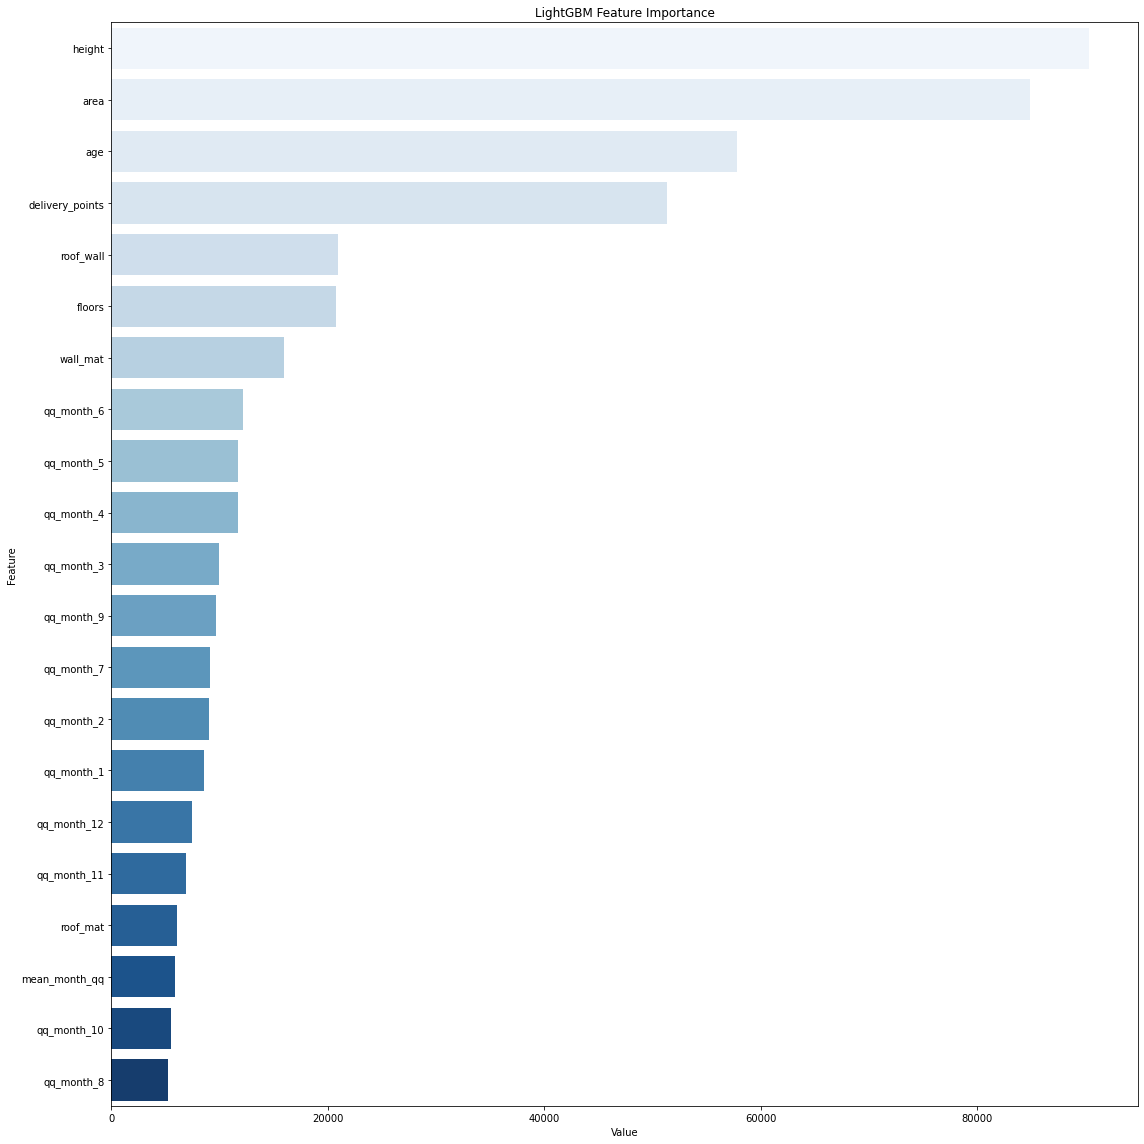

In [75]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='split'), features),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(16, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30), 
            palette='Blues')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

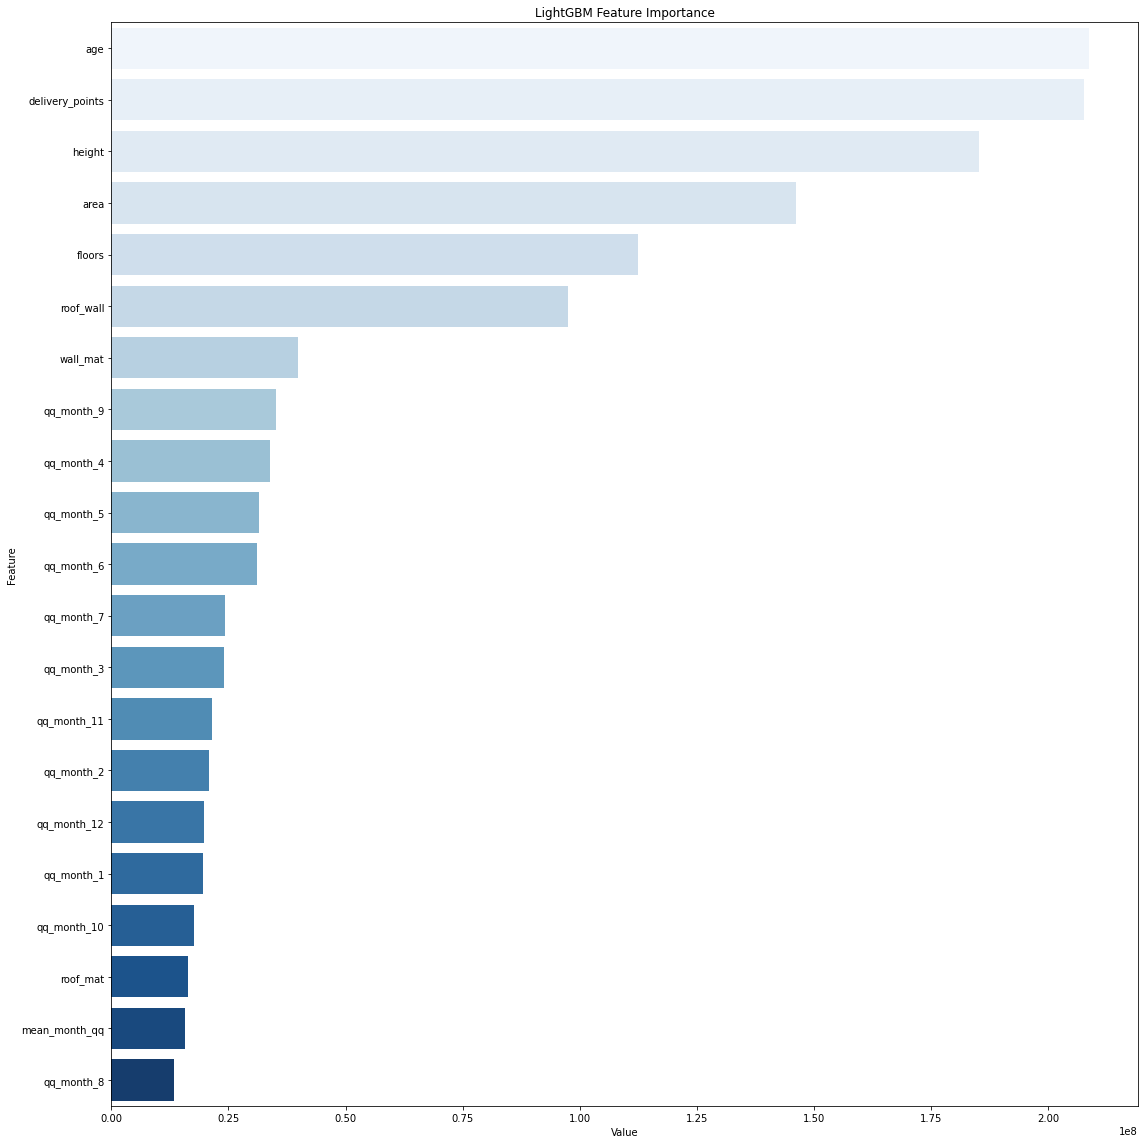

In [76]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'), features),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(16, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30), 
            palette='Blues')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()


In [77]:
# Including CENSUS data

In [78]:
features = [
 'delivery_points',
 'height',
 'age',
 'floors',
 'wall_mat',
 'roof_mat',
 'roof_wall',
 'area',
 'CHFL_1',
 'CHFL_2',
 'CHFL_3',
 'CHFL_4',
 'CHFL_X',
 'CMBL_1',
 'CMBL_2',
 'CMBL_3',
 'CMBL_4',
 'CMBL_5',
 'CMBL_6',
 'CMBL_X',
 'NPERR_1',
 'NPERR_2',
 'NPERR_3',
 'NPERR_4',
 'NPERR_5',
 'NPERR_6',
 'NPERR_Z',
 'STATR_1',
 'STATR_2',
 'STATR_Z',
 'NENFR_0',
 'NENFR_1',
 'NENFR_2',
 'NENFR_3',
 'NENFR_4',
 'NENFR_Z',
 'CHFL1_CMBL_1',
 'CHFL1_CMBL_2',
 'CHFL1_CMBL_3',
 'CHFL1_CMBL_4',
 'CHFL1_CMBL_5',
 'CHFL1_CMBL_6',
 'CHFL2_CMBL_2',
 'CHFL2_CMBL_3',
 'CHFL2_CMBL_4',
 'CHFL2_CMBL_5',
 'CHFL2_CMBL_6',
 'qq_month_1',
 'qq_month_2',
 'qq_month_3',
 'qq_month_4',
 'qq_month_5',
 'qq_month_6',
 'qq_month_7',
 'qq_month_8',
 'qq_month_9',
 'qq_month_10',
 'qq_month_11',
 'qq_month_12',
 'mean_month_qq']

In [79]:
X = train[features]
y = train[target]
y_oof_pred = np.zeros(len(y))

X_test = test[features].values
y_test_pred = np.zeros(len(X_test))

In [80]:
error = 0
SEED=42

num_folds = 5
kf = KFold(n_splits = num_folds)

for i, (train_index, val_index) in enumerate(kf.split(X, y)):  
    print(f"Fold {i+1}")

    X_train = X.loc[train_index].values
    X_val = X.loc[val_index].values
    y_train = y[train_index].values
    y_val = y[val_index].values

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val)

    params_lgb = {
        'objective' : 'regression',
        'metric': 'rmse',
        'force_col_wise': True,
        'seed' : SEED,
        'num_iterations' : 15000,
        'early_stopping_rounds' : 250,
        'learning_rate' : 0.05,
        'max_depth' : 8,
        'num_leaves' : 32,
        'feature_fraction': 0.9,
        'lambda_l1' : 0.1,
        'lambda_l2' : 0.1,
        'verbose' : -1
    }

    model = lgb.train(params=params_lgb,
                      train_set=lgb_train,
                      valid_sets = (lgb_train, lgb_eval),
                      verbose_eval = 250,
                     )


    y_val_pred = model.predict(X_val)
    y_test_pred += model.predict(X_test)
    
    rmse_fold = np.sqrt(mean_squared_error(y_val_pred, y_val))
    error += rmse_fold
    y_oof_pred[val_index] = y_val_pred


print(f"Mean RMSE: {error/num_folds}")
print(f"Mean RMSE: {np.sqrt(mean_squared_error(y_oof_pred, y))}")


# Calculate evaluation metric for out of fold validation set
y_test_pred = y_test_pred / num_folds
print(f"Mean RMSE in test over the n folds: {np.sqrt(mean_squared_error(y_test_pred, y_test))}")


Fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 250 rounds
[250]	training's rmse: 31.941	valid_1's rmse: 34.4898
[500]	training's rmse: 29.0747	valid_1's rmse: 33.3031
[750]	training's rmse: 26.8705	valid_1's rmse: 32.631
[1000]	training's rmse: 25.1307	valid_1's rmse: 32.2294
[1250]	training's rmse: 23.6383	valid_1's rmse: 31.9469
[1500]	training's rmse: 22.223	valid_1's rmse: 31.7051
[1750]	training's rmse: 21.0723	valid_1's rmse: 31.5642
[2000]	training's rmse: 20.0011	valid_1's rmse: 31.4433
[2250]	training's rmse: 19.0234	valid_1's rmse: 31.3424
[2500]	training's rmse: 18.1425	valid_1's rmse: 31.2595
[2750]	training's rmse: 17.3101	valid_1's rmse: 31.1923
[3000]	training's rmse: 16.6045	valid_1's rmse: 31.1236
[3250]	training's rmse: 15.9129	valid_1's rmse: 31.0993
[3500]	training's rmse: 15.3009	valid_1's rmse: 31.0598
[3750]	training's rmse: 14.742	valid_1's rmse: 31.0325
[4000]	training's rmse: 14.2095	valid_1's rmse: 31.0026
[4250]	training's rmse: 13.6687	valid_1's rmse: 3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[250]	training's rmse: 31.8641	valid_1's rmse: 34.7739
[500]	training's rmse: 28.9646	valid_1's rmse: 33.5898
[750]	training's rmse: 26.7885	valid_1's rmse: 32.9019
[1000]	training's rmse: 25.0798	valid_1's rmse: 32.47
[1250]	training's rmse: 23.5394	valid_1's rmse: 32.1383
[1500]	training's rmse: 22.2308	valid_1's rmse: 31.9025
[1750]	training's rmse: 21.065	valid_1's rmse: 31.719
[2000]	training's rmse: 20.0523	valid_1's rmse: 31.5795
[2250]	training's rmse: 19.0998	valid_1's rmse: 31.4659
[2500]	training's rmse: 18.2797	valid_1's rmse: 31.3976
[2750]	training's rmse: 17.5283	valid_1's rmse: 31.3339
[3000]	training's rmse: 16.825	valid_1's rmse: 31.2606
[3250]	training's rmse: 16.1668	valid_1's rmse: 31.2209
[3500]	training's rmse: 15.5592	valid_1's rmse: 31.1592
[3750]	training's rmse: 14.9797	valid_1's rmse: 31.1197
[4000]	training's rmse: 14.424	valid_1's rmse: 31.0833
[4250]	training's rmse: 13.8785	valid_1's rmse: 31.0735
[4500]	training's rmse: 13.3862	valid_1's rmse: 31.0749


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 250 rounds
[250]	training's rmse: 32.0892	valid_1's rmse: 33.9835
[500]	training's rmse: 29.1703	valid_1's rmse: 32.7197
[750]	training's rmse: 27.06	valid_1's rmse: 32.0236
[1000]	training's rmse: 25.2469	valid_1's rmse: 31.4701
[1250]	training's rmse: 23.7338	valid_1's rmse: 31.1398
[1500]	training's rmse: 22.4464	valid_1's rmse: 30.8854
[1750]	training's rmse: 21.2706	valid_1's rmse: 30.6665
[2000]	training's rmse: 20.1985	valid_1's rmse: 30.5135
[2250]	training's rmse: 19.2142	valid_1's rmse: 30.3876
[2500]	training's rmse: 18.3662	valid_1's rmse: 30.3003
[2750]	training's rmse: 17.5498	valid_1's rmse: 30.2379
[3000]	training's rmse: 16.8361	valid_1's rmse: 30.1775
[3250]	training's rmse: 16.1971	valid_1's rmse: 30.1352
[3500]	training's rmse: 15.5813	valid_1's rmse: 30.0877
[3750]	training's rmse: 14.9709	valid_1's rmse: 30.0439
[4000]	training's rmse: 14.402	valid_1's rmse: 30.0263
[4250]	training's rmse: 13.8735	valid_1's rmse: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[250]	training's rmse: 31.861	valid_1's rmse: 35.0766
[500]	training's rmse: 28.8686	valid_1's rmse: 33.8117
[750]	training's rmse: 26.7179	valid_1's rmse: 33.0936
[1000]	training's rmse: 24.9561	valid_1's rmse: 32.6459
[1250]	training's rmse: 23.4504	valid_1's rmse: 32.2721
[1500]	training's rmse: 22.1594	valid_1's rmse: 32.0019
[1750]	training's rmse: 21.047	valid_1's rmse: 31.8114
[2000]	training's rmse: 19.9886	valid_1's rmse: 31.6425
[2250]	training's rmse: 19.0696	valid_1's rmse: 31.5414
[2500]	training's rmse: 18.1894	valid_1's rmse: 31.4665
[2750]	training's rmse: 17.4068	valid_1's rmse: 31.397
[3000]	training's rmse: 16.7131	valid_1's rmse: 31.3282
[3250]	training's rmse: 16.0593	valid_1's rmse: 31.2761
[3500]	training's rmse: 15.4446	valid_1's rmse: 31.2148
[3750]	training's rmse: 14.8314	valid_1's rmse: 31.1894
[4000]	training's rmse: 14.2695	valid_1's rmse: 31.1512
[4250]	training's rmse: 13.757	valid_1's rmse: 31.137
[4500]	training's rmse: 13.2912	valid_1's rmse: 31.1139

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[250]	training's rmse: 31.8407	valid_1's rmse: 34.8719
[500]	training's rmse: 28.9221	valid_1's rmse: 33.7281
[750]	training's rmse: 26.7526	valid_1's rmse: 33.058
[1000]	training's rmse: 25.0156	valid_1's rmse: 32.6395
[1250]	training's rmse: 23.4741	valid_1's rmse: 32.3161
[1500]	training's rmse: 22.1496	valid_1's rmse: 32.0738
[1750]	training's rmse: 20.9815	valid_1's rmse: 31.9196
[2000]	training's rmse: 19.9589	valid_1's rmse: 31.7644
[2250]	training's rmse: 19.0411	valid_1's rmse: 31.6658
[2500]	training's rmse: 18.1896	valid_1's rmse: 31.5838
[2750]	training's rmse: 17.3759	valid_1's rmse: 31.4947
[3000]	training's rmse: 16.6166	valid_1's rmse: 31.4104
[3250]	training's rmse: 15.9444	valid_1's rmse: 31.3448
[3500]	training's rmse: 15.3079	valid_1's rmse: 31.2837
[3750]	training's rmse: 14.7332	valid_1's rmse: 31.2438
[4000]	training's rmse: 14.2144	valid_1's rmse: 31.2239
[4250]	training's rmse: 13.7247	valid_1's rmse: 31.2067
[4500]	training's rmse: 13.2691	valid_1's rmse: 31.1

In [81]:
#Train on the whole dataset
lgb_final = lgb.Dataset(X, y)
params_lgb = {
    'objective' : 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'seed' : SEED,
    'num_iterations' : 15000,
    'learning_rate' : 0.05,
    'max_depth' : 8,
    'num_leaves' : 32,
    'feature_fraction': 0.9,
    'lambda_l1' : 0.1,
    'lambda_l2' : 0.1,
    'verbose' : -1
}

model = lgb.train(params=params_lgb,
                  train_set=lgb_final
                 )


y_final_pred = model.predict(X_test)
print(f"Mean RMSE in test with the final model: {np.sqrt(mean_squared_error(y_final_pred, y_test))}")


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Mean RMSE in test with the final model: 30.659416459809165


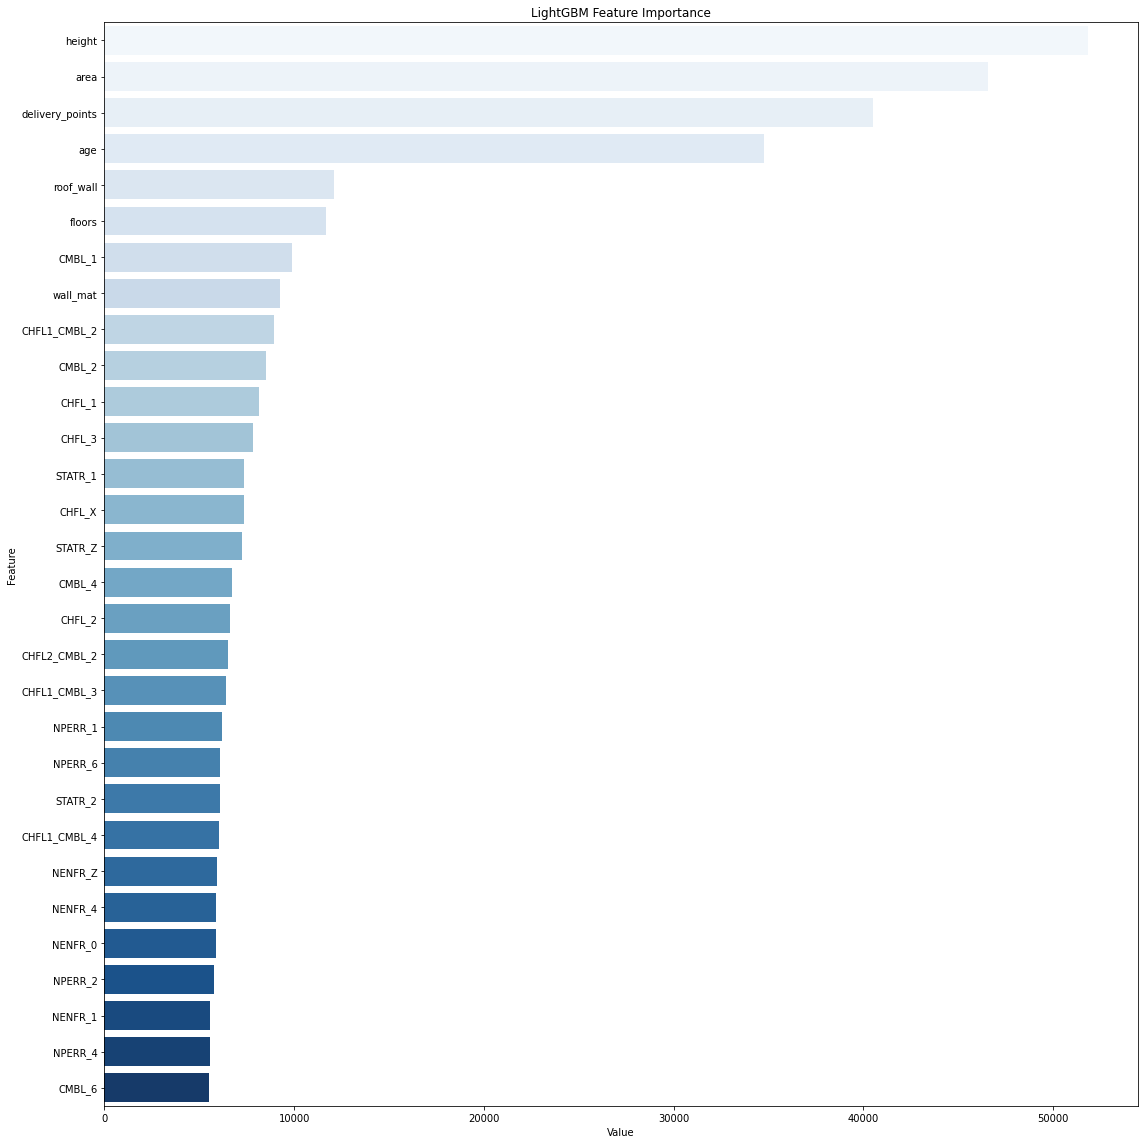

In [82]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='split'), features),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(16, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30), 
            palette='Blues')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

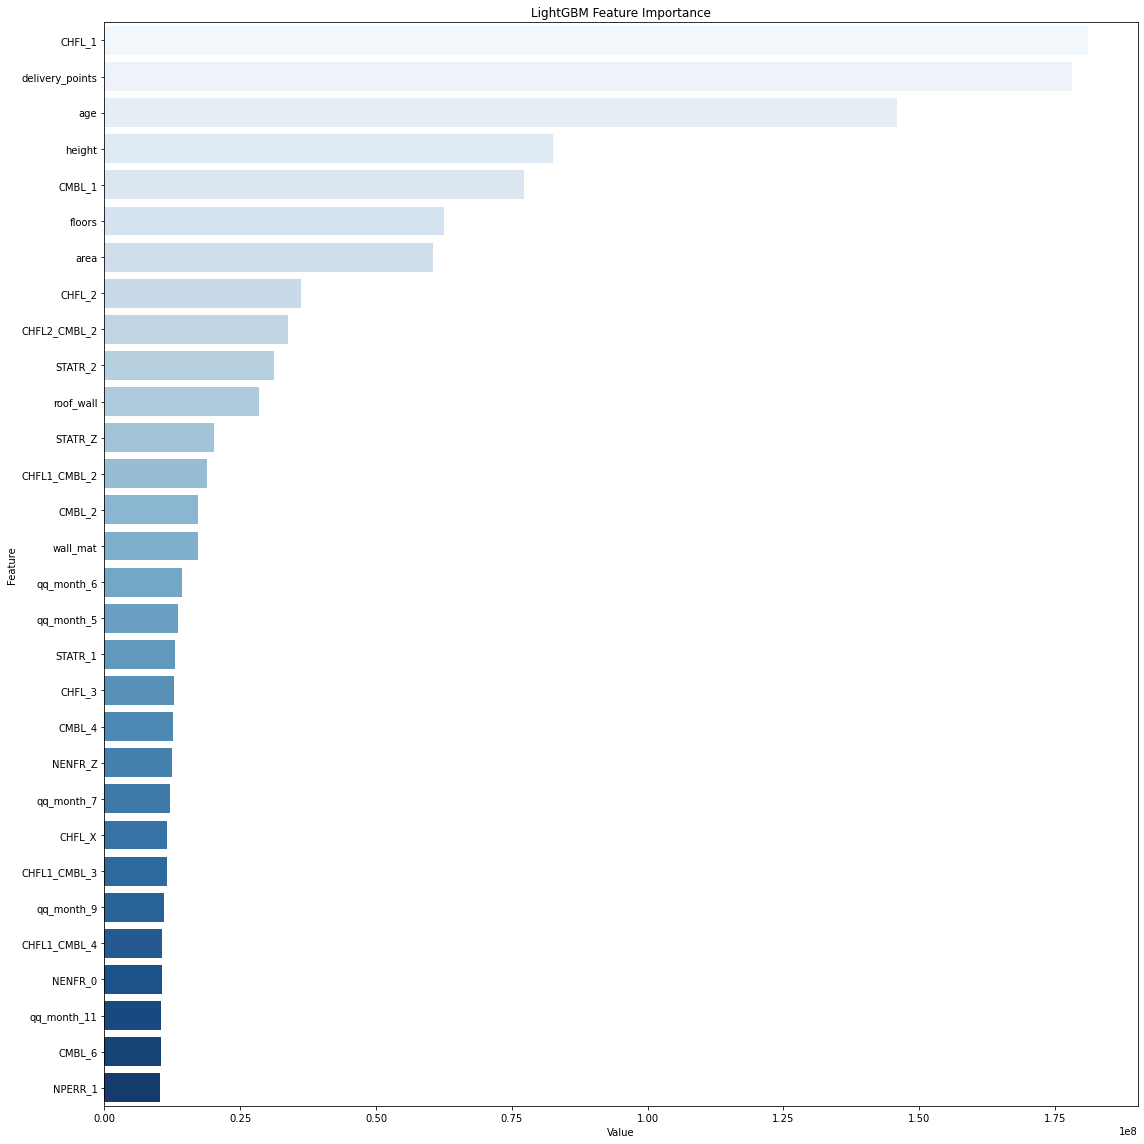

In [83]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'), features),reverse = True), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value != 0]
plt.figure(figsize=(16, 16))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30), 
            palette='Blues')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

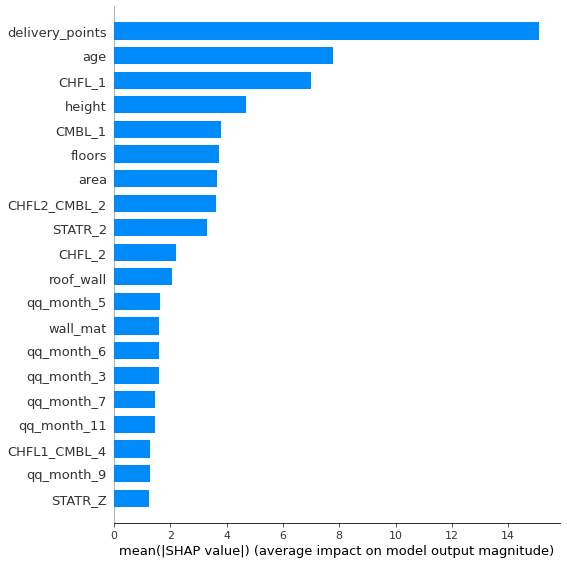

In [84]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

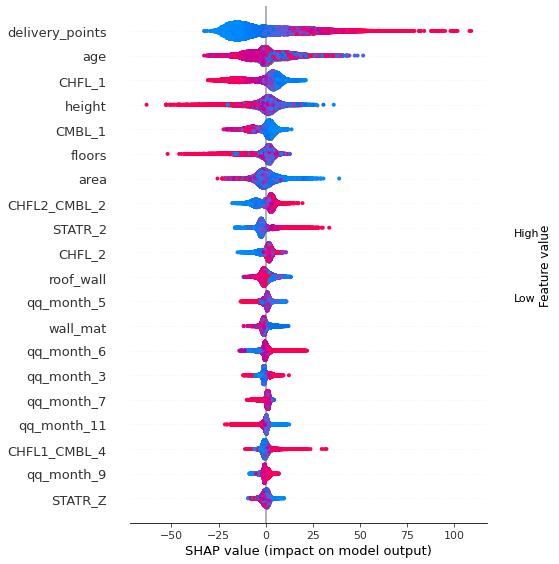

In [85]:
shap.summary_plot(shap_values, X)

# Random Forest

In [86]:
features = [
 'delivery_points',
 'height',
 'age',
 'floors',
 'wall_mat',
 'roof_mat',
 'roof_wall',
 'area',
 'qq_month_1',
 'qq_month_2',
 'qq_month_3',
 'qq_month_4',
 'qq_month_5',
 'qq_month_6',
 'qq_month_7',
 'qq_month_8',
 'qq_month_9',
 'qq_month_10',
 'qq_month_11',
 'qq_month_12',
 'mean_month_qq']

In [87]:
X = train.fillna(0)[features]
y = train.fillna(0)[target]
y_oof_pred = np.zeros(len(y))

X_test = test.fillna(0)[features]
y_test_pred = np.zeros(len(X_test))

In [88]:
from sklearn.ensemble import RandomForestRegressor
error = 0
SEED=42

num_folds = 5
kf = KFold(n_splits = num_folds)

for i, (train_index, val_index) in enumerate(kf.split(X, y)):  
    print(f"Fold {i+1}")

    X_train = X.loc[train_index]
    X_val = X.loc[val_index]
    y_train = y[train_index]
    y_val = y[val_index]

    rf= RandomForestRegressor(
            n_estimators = 100,
            max_depth    = 6,
            max_features = 10,
            random_state = SEED
         )

    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    y_test_pred += rf.predict(X_test)
    
    rmse_fold = np.sqrt(mean_squared_error(y_val_pred, y_val))
    error += rmse_fold
    y_oof_pred[val_index] = y_val_pred


print(f"Mean RMSE: {error/num_folds}")
print(f"Mean RMSE: {np.sqrt(mean_squared_error(y_oof_pred, y))}")


# Calculate evaluation metric for out of fold validation set
y_test_pred = y_test_pred / num_folds
print(f"Mean RMSE in test over the n folds: {np.sqrt(mean_squared_error(y_test_pred, y_test))}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Mean RMSE: 42.31540953696613
Mean RMSE: 42.316748311419836
Mean RMSE in test over the n folds: 42.2740444187372


In [89]:
#Train on the whole dataset
rf_final= RandomForestRegressor(
            n_estimators = 100,
            max_depth    = 6,
            max_features = 10,
            random_state = SEED
         )

rf_final.fit(X, y)


y_final_pred = rf_final.predict(X_test)
print(f"Mean RMSE in test with the final model: {np.sqrt(mean_squared_error(y_final_pred, y_test))}")


Mean RMSE in test with the final model: 42.30680317973372


In [90]:
#Random forest with census variables

In [91]:
features = [
 'delivery_points',
 'height',
 'age',
 'floors',
 'wall_mat',
 'roof_mat',
 'roof_wall',
 'area',
 'CHFL_1',
 'CHFL_2',
 'CHFL_3',
 'CHFL_4',
 'CHFL_X',
 'CMBL_1',
 'CMBL_2',
 'CMBL_3',
 'CMBL_4',
 'CMBL_5',
 'CMBL_6',
 'CMBL_X',
 'NPERR_1',
 'NPERR_2',
 'NPERR_3',
 'NPERR_4',
 'NPERR_5',
 'NPERR_6',
 'NPERR_Z',
 'STATR_1',
 'STATR_2',
 'STATR_Z',
 'NENFR_0',
 'NENFR_1',
 'NENFR_2',
 'NENFR_3',
 'NENFR_4',
 'NENFR_Z',
 'CHFL1_CMBL_1',
 'CHFL1_CMBL_2',
 'CHFL1_CMBL_3',
 'CHFL1_CMBL_4',
 'CHFL1_CMBL_5',
 'CHFL1_CMBL_6',
 'CHFL2_CMBL_2',
 'CHFL2_CMBL_3',
 'CHFL2_CMBL_4',
 'CHFL2_CMBL_5',
 'CHFL2_CMBL_6',
 'qq_month_1',
 'qq_month_2',
 'qq_month_3',
 'qq_month_4',
 'qq_month_5',
 'qq_month_6',
 'qq_month_7',
 'qq_month_8',
 'qq_month_9',
 'qq_month_10',
 'qq_month_11',
 'qq_month_12',
 'mean_month_qq']

In [92]:
X = train.fillna(0)[features]
y = train.fillna(0)[target]
y_oof_pred = np.zeros(len(y))

X_test = test.fillna(0)[features]
y_test_pred = np.zeros(len(X_test))

In [93]:
from sklearn.ensemble import RandomForestRegressor
error = 0
SEED=42

num_folds = 5
kf = KFold(n_splits = num_folds)

for i, (train_index, val_index) in enumerate(kf.split(X, y)):  
    print(f"Fold {i+1}")

    X_train = X.loc[train_index]
    X_val = X.loc[val_index]
    y_train = y[train_index]
    y_val = y[val_index]

    rf= RandomForestRegressor(
            n_estimators = 100,
            max_depth    = 6,
            max_features = 10,
            random_state = SEED
         )

    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    y_test_pred += rf.predict(X_test)
    
    rmse_fold = np.sqrt(mean_squared_error(y_val_pred, y_val))
    error += rmse_fold
    y_oof_pred[val_index] = y_val_pred


print(f"Mean RMSE: {error/num_folds}")
print(f"Mean RMSE: {np.sqrt(mean_squared_error(y_oof_pred, y))}")


# Calculate evaluation metric for out of fold validation set
y_test_pred = y_test_pred / num_folds
print(f"Mean RMSE in test over the n folds: {np.sqrt(mean_squared_error(y_test_pred, y_test))}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Mean RMSE: 40.90764157709525
Mean RMSE: 40.90931441027145
Mean RMSE in test over the n folds: 40.750580608827846


In [94]:
#Train on the whole dataset
rf_final= RandomForestRegressor(
            n_estimators = 100,
            max_depth    = 6,
            max_features = 10,
            random_state = SEED
         )

rf_final.fit(X, y)


y_final_pred = rf_final.predict(X_test)
print(f"Mean RMSE in test with the final model: {np.sqrt(mean_squared_error(y_final_pred, y_test))}")

Mean RMSE in test with the final model: 40.82521876933704
